In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys

sys.path.append("../")

import pandas as pd
import numpy as np
from src.utils import get_data_and_feed, plot_experiment

FILENAME = "../data/data_processed.xlsx"
EXPERIMENT = "BR01"
S_IN = 1.43 * 200

NUM_POINTS = 10000

Dataset shape: (11, 8)


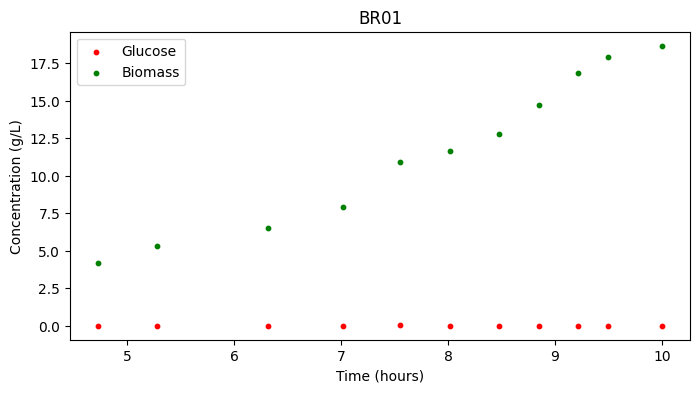

In [3]:
full_df, feeds = get_data_and_feed(
    file_name=FILENAME, experiment=EXPERIMENT, keep_only="FB"
)

# Get initial volume
V0 = full_df["V"].iloc[0]

print(f"Dataset shape: {full_df.shape}")

plot_experiment(full_df, title=EXPERIMENT)

In [12]:
# Generate dataset
df = pd.DataFrame(columns=['t', 'Biomass', 'Glucose'])
df['Biomass'] = np.random.uniform(2.5, 5, NUM_POINTS)
df['Glucose'] = full_df['Glucose'].iloc[0]
df['t'] = 0.0
df['F'] = np.random.uniform(15, 35, NUM_POINTS)

print(f'Dataset shape: {df.shape}')

Dataset shape: (10000, 4)
